# MAT245 Lab 5 - Linear Regression

## Overview 


Regression analysis is a set of statistical techniques for modelling the relationships between a dependent variable and a set of independent (or *predictor*) variables. Linear regression in particular assumes these relationships are linear. We are going to explore a few different ways of finding "optimal" parameters for a linear regression model. 

## Loading the data

We will be working with a subset of `scikit-learn`'s Boston housing dataset. The goal is to construct a linear regression model that predicts the price of a house given a few metrics about the neighbourhood it's in. The Boston data can be loaded by:

In [31]:
from sklearn import datasets

bost = datasets.load_boston()
bost.keys()

dict_keys(['feature_names', 'target', 'data', 'DESCR'])

In [32]:
bost.data.shape

(506, 13)

There are thirteen columns of data, and 506 samples. A description of what each column means can be found by investigating  `bost['DESCR']`. For visualization purposes, we'll work with a 2 dimensional subset:  

In [33]:
xs = bost.data[:, [2, 12]]

The data in column index `2` represents proportion of non-retail business acres in the town, while column index `12` is the median value of owner-occupied homes in the neighbourhood, priced in $1000's.

The target variable (i.e. what we want to predict) are the house prices, these are stored in `bost.target`. Let's plot house prices as a function of our inputs to see what we're dealing with.

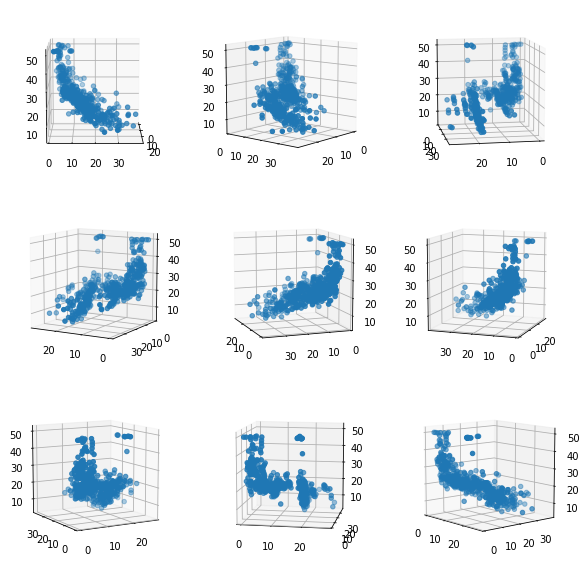

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
for i in range(1, 10):
    ax = fig.add_subplot(3, 3, i, projection='3d')
    ax.view_init(elev=10., azim = (360.0 / 9.) * (i - 1))
    ax.scatter(xs[:,0], xs[:,1], bost.target)
    
plt.show()

## Linear regression via the normal equations

It's clear from inspecting the graphs above that we can't make perfect predictions given the limited information we have, but we'll do the best we can. Rememeber, we want to model our dependent variable $\hat{y}$ (in this case house price) as a linear function of the inputs $x = (x_1, x_2)$:

$$
\hat{y} = \theta_0 + \theta_1 x_1 + \theta_2 x_2 = \theta \cdot x \quad \text{where }\theta_i \in \mathbb{R}.
$$

Let's apply this to our current situation. There are $N$ samples in our dataset, with $N = 506$; denote the $i^{th}$ one by $x^i = (x_1^i, x_2^i)$. This means we want to predict the $i^{th}$ house price according to

$$
\hat{y}^i = \theta_0 + \theta_1 x^i_1 + \theta_2 x^i_2.
$$

If 

$$
\hat{y} = 
\begin{pmatrix}
  \hat{y}^1 \\
  \hat{y}^2 \\
  \vdots    \\
  \hat{y}^N
\end{pmatrix}
\quad \text{and} \quad
X = 
\begin{pmatrix}
  1 & x^1_1  & x^1_2 \\
  1 & x^2_1  & x^2_2 \\
    & \vdots &       \\
  1 & x^N_1  & x^N_2
\end{pmatrix}
$$

then we can rewrite this in matrix notation:

$$
X\theta = \hat{y}.
$$

If we let $y \in \mathbb{R}^N$ denote the actual housing prices, then the objective becomes finding $\theta = (\theta_0, \theta_1, \theta_2)$ that minimizes the mean squared error (also called loss or cost):

$$
\begin{align}
J(\theta) &= \frac{1}{2N} \sum_{i=1}^N (\hat{y}^i - y^i)^2 \\
          &= \frac{1}{2N} (X \theta - y) \cdot (X \theta - y)
\end{align}
$$

(Note that this is just a rescaling of the squared Euclidean distance by $1/2N$.) We can minimize $J$ by taking its gradient with respect to $\theta$ and setting it equal to zero. Computing the gradient explicitly yields


$$
\begin{align}
\nabla J(\theta) 
  &= 
\frac{1}{2N} \left[ X^T (X\theta - y) + X^T (X\theta - y)\right] \\
  &= 
\frac{1}{N} \left[ X^T (X\theta - y) \right].
\end{align}
$$

Equating to zero and solving gives an explicit analytic solution for the optimal regression parameters $\theta$:

$$
\theta = (X^T X)^{-1} X^T y.
$$

This equation is called the *normal equation*.

**Aside:** To compute $\nabla J(\theta)$ we use the general fact that, for functions $a(\theta)$ and $b(\theta)$, the gradient of the dot product is computed by

$$
\begin{align}
  \nabla a(\theta) \cdot b(\theta) &= \nabla \sum_{i=1}^N a^i(\theta) b^i(\theta) \\
    &= \sum_{i=1}^N (\nabla a^i(\theta))b^i(\theta) + a^i (\nabla b^i(\theta)) \\
    &= \left( \frac{\partial a^i}{\partial \theta_j} \right)_{ij}^T b + 
       \left( \frac{\partial b^i}{\partial \theta_j} \right)_{ij}^T a;
\end{align}
$$

plugging in $a(\theta) = b(\theta) = (X\theta - y)$ gives the desired result.

Goals (1):

- Solve the normal equations explicitly for the boston data to obtain the regression parameters $\theta$. In other words compute $\theta$ directly using formula $\theta = (X^T X)^{-1} X^T y$. 
- Estimate the error in your computations for $\theta$ by investigating the condition number of $X^T X$. (see `numpy.linalg.cond`.) 
- Plot the plane described by the function $(x_1, x_2) \mapsto \theta_0 + \theta_1 x_1 + \theta_2 x_2$ alongside the data to see how good this approximation is.


## Linear Regression via gradient descent

Gradient descent is an interative procedure for (approximately) finding minima of functions. Let's apply it to our function $J(\theta)$. 

First we need to pick a point to begin our seach from, so let's fix some initial point $\theta^{(0)}$ in the domain of $J$. Recall that the gradient $\nabla J(\theta^{(0)})$ points in the direction of greatest increase of $J$. So, if we move in the direction of the negative gradient $- \nabla J(\theta^{(0)})$, i.e. if we set 

$$
  \theta^{(1)} = \theta^{(0)} - \gamma \nabla J(\theta^{(0)}).  
$$

then $\theta^{(1)}$ should satisfy $J(\theta^{(1)}) \leq J(\theta^{(0)})$. The parameter $\gamma > 0$ is called the *learning rate*. Of course if $\gamma$ is too large it is possible to take too large a step and "overshoot" a minimum of $J$, so it's important to choose an appropriate learning rate. 

The idea is to repeat this procedure to get sequence $\{ \theta^{(0)}, \theta^{(1)}, \dots \}$ such that

$$
J(\theta^{(n+1)}) \leq J(\theta^{(n)})
$$

until the error $J$ is sufficiently small. In practice however, $J$ is often not a perfectly convex function, so avoiding local minima becomes a problem. 

Goals (2):

- Implement a `python` program that computes $\nabla J$ (see the equations in section 1 for an explicit formula for this gradient). 

- Implement a `python` function that maps $(\theta, \gamma) \mapsto \theta - \gamma \nabla J(\theta)$. Use this function to compute regression parameters via gradient descent.


## Linear Regression via QR decomposition

When solving an equation of the form

$$
  X\theta = y
$$

we often want to avoid forming the product $X^T X$. For instance, if the columns of $X$ are "almost linearly dependent", the floating point approximation $X^T X$ can reduce to a singular matrix. For example, suppose

$$
X = \begin{bmatrix}
1 & -1 \\
0 & 10^{-5}  \\
0 & 0 \\
\end{bmatrix}
\quad \text{and} \quad
y = \begin{bmatrix}
0 \\
10^{-5}  \\
1  \\
\end{bmatrix}
$$

then

$$
X^TX = \begin{bmatrix}
1 & -1 \\
-1 & 1+10^{-10}  \\
\end{bmatrix}
\quad \text{which gets rounded to} \quad
\begin{bmatrix}
1 & -1 \\
-1 & 1  \\
\end{bmatrix}.
$$

Since the rounded matrix is singular, we can't take its inverse; attempting to solve the normal equations leads to an error.

We get around this by using the $QR$ decomposition of $X$. Since the columns of $Q$ are linearly independent, and $R$ is square, upper-triangular, we can solve the linear system by computing

$$
\theta = R^{-1} Q^T y.
$$

Goals (3):

- Use the $QR$ factorization to solve for the regression coefficients $\theta$. 
- Using this $\theta$ value, plot the graph of $(x_1, x_2) \mapsto \theta_0 + \theta_1 x_1 + \theta_2 x_2$ as in part (1). 